In [144]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image

In [2]:
img_dir = '/Users/antipins/Documents/Mask_Detected/images/'             # Путь до файлов
annot_dir = '/Users/antipins/Documents/Mask_Detected/annotations'

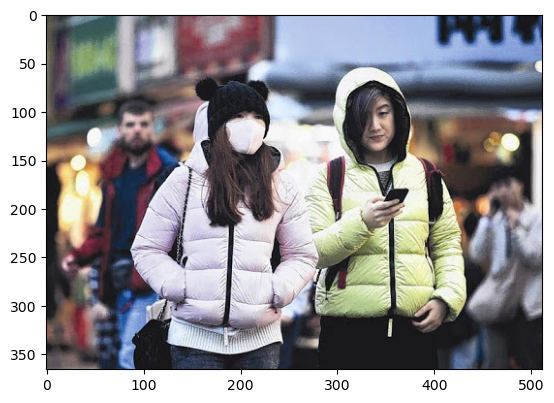

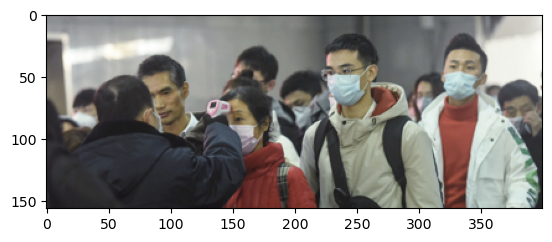

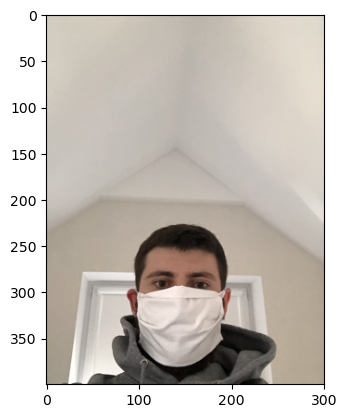

In [3]:
for idx, image in enumerate(os.listdir(img_dir)):  # listdir открывает все, что находится в папке img_dir
    img = cv2.imread(os.path.join(img_dir, image)) # Соединение пути и объекта (img_dir и image)
    imageRGB = cv2.cvtColor(img , cv2.COLOR_BGR2RGB) # Изначально передаются цвета в формате BGR, поэтому все фотки синие
    plt.imshow(imageRGB)                             # cv2.COLOR_BGR2RGB преобразует в правильную последовательнось цветов
    plt.show()                                       # Изначально она BGR( поэтому картинки уходят в синий цвет)
    if idx==2:
        break

In [4]:
img_file = []                                         # Создание пустого списка
for img in os.listdir(img_dir):                       # Итерация по объектам
    images = cv2.imread(os.path.join(img_dir, img))   # Соединение пути с объектом
    img_file.append(images)                           # Добавление в список (переводит в array)

In [5]:
import xml.etree.ElementTree as ET
import glob

In [6]:
# Два варианта вытащить полный путь до файла

# glob.glob(annot_dir + '/*xml')       # Путь до файла целиком

# exemple = []
# for anno in os.listdir(annot_dir):      # Либо без использования glob,с помощью итарации
#     ex = os.path.join(annot_dir, anno)  # Оба варианта будут идентичными
#     exemple.append(ex)

In [7]:
df = {'name': [],      # Создание словаря, который в будущем будет переделан в датафрейм
     'label': [],
     'widht': [],
     'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}

width = []
height = []

for idx, anno in enumerate(glob.glob(annot_dir + '/*.xml')):                    # Итерация по индексам и пути файла
    trees = ET.parse(anno).getroot()                                            # Создание корня 
    for item in trees.iter():                                                   # Итерация по всему дереву файла
        if item.tag == 'size':                                                  # Поиск по tag
            for attr in list(item):                                             # Переход в следующую ветвь
                if attr.tag =='width':
                    width = int(attr.text)                                      # Если сразу добавлять в датасет
                if attr.tag == 'height':                                        # будет несоответствие размеров
                    height = int(attr.text)
                                                                                # В остальном все идентично
        if item.tag == 'object':
            for attr in list(item):
                if attr.tag == 'name':
                    df['label'].append(attr.text)
                    df['widht'].append(width)
                    df['height'].append(height)
                    df['name'].append(anno.split('/')[-1].split('\\')[-1][0:-4])
                    
                if attr.tag == 'bndbox':
                    for coor in list(attr):
                        if coor.tag == 'xmin':
                            df['xmin'].append(int(coor.text))
                        if coor.tag == 'ymin':
                            df['ymin'].append(int(coor.text))
                        if coor.tag == 'xmax':
                            df['xmax'].append(int(coor.text))
                        if coor.tag == 'ymax':
                            df['ymax'].append(int(coor.text))

In [8]:
data = pd.DataFrame(df)
data.head()

,name,label,widht,height,xmin,ymin,xmax,ymax
0,maksssksksss0,without_mask,512,366,79,105,109,142
1,maksssksksss0,with_mask,512,366,185,100,226,144
2,maksssksksss0,without_mask,512,366,325,90,360,141
3,maksssksksss1,with_mask,400,156,321,34,354,69
4,maksssksksss1,with_mask,400,156,224,38,261,73


In [10]:
data.label.unique()

array(['without_mask', 'with_mask', 'mask_weared_incorrect'], dtype=object)

In [11]:
class_dict = {'without_mask': 0,
          'with_mask': 1,
          'mask_weared_incorrect': 2}
data['class'] = data['label'].map( class_dict)

In [12]:
data

,name,label,widht,height,xmin,ymin,xmax,ymax,class
0,maksssksksss0,without_mask,512,366,79,105,109,142,0
1,maksssksksss0,with_mask,512,366,185,100,226,144,1
2,maksssksksss0,without_mask,512,366,325,90,360,141,0
3,maksssksksss1,with_mask,400,156,321,34,354,69,1
4,maksssksksss1,with_mask,400,156,224,38,261,73,1
...,...,...,...,...,...,...,...,...,...
4067,maksssksksss98,with_mask,400,267,263,62,287,85,1
4068,maksssksksss98,with_mask,400,267,344,80,377,106,1
4069,maksssksksss99,mask_weared_incorrect,400,267,181,54,273,162,2
4070,maksssksksss99,with_mask,400,267,99,87,176,165,1


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    4072 non-null   object
 1   label   4072 non-null   object
 2   widht   4072 non-null   int64 
 3   height  4072 non-null   int64 
 4   xmin    4072 non-null   int64 
 5   ymin    4072 non-null   int64 
 6   xmax    4072 non-null   int64 
 7   ymax    4072 non-null   int64 
 8   class   4072 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 286.4+ KB


In [14]:
from sklearn.model_selection import train_test_split
fileNames = os.listdir(img_dir)
train, test = train_test_split(fileNames, test_size=0.15, random_state = 42)
test, val = train_test_split(test, test_size = 0.3, random_state=42)
print('Length \
      train: {} \
      test: {} \
      val: {} '. format(len(train), len(test), len(val)))

Length       train: 725       test: 89       val: 39 


In [25]:
# os.mkdir('./yolov5/data/train')
# os.mkdir('./yolov5/data/val')
# os.mkdir('./yolov5/data/test')
# os.mkdir('./yolov5/data/train/images')
# os.mkdir('./yolov5/data/train/labels')
# os.mkdir('./yolov5/data/test/images')
# os.mkdir('./yolov5/data/test/labels')
# os.mkdir('./yolov5/data/val/images')
# os.mkdir('./yolov5/data/val/labels')

In [15]:
from PIL import Image

def copyImages(imageList, folder_Name):
    for image in imageList:
        img = Image.open('/Users/antipins/Documents/Mask_Detected/images/'
+image)
        img1 = img.resize((640, 480))
        _ = img1.save("./yolov5/data/"+folder_Name+"/images/"+image)

In [28]:
# copyImages(train, "train")
# copyImages(val, "val")
# copyImages(test, "test")

In [30]:
data.head()

,name,label,widht,height,xmin,ymin,xmax,ymax,class
0,maksssksksss0,without_mask,512,366,79,105,109,142,0
1,maksssksksss0,with_mask,512,366,185,100,226,144,1
2,maksssksksss0,without_mask,512,366,325,90,360,141,0
3,maksssksksss1,with_mask,400,156,321,34,354,69,1
4,maksssksksss1,with_mask,400,156,224,38,261,73,1


In [16]:
data['xmin'] = (640/data['widht']) * data['xmin']       # Изменение параметров x и y под новый размер изображений
data['ymin'] = (480/data['height']) * data['ymin']
data['xmax'] = (640/data['widht']) * data['xmax']
data['ymax'] = (480/data['height']) * data['ymax']

In [27]:
data[['xmin', 'ymin', 'xmax', 'ymax']] = data[['xmin', 'ymin', 'xmax', 'ymax']].astype(int) # Из флот в инт

In [28]:
data

,name,label,widht,height,xmin,ymin,xmax,ymax,class
0,maksssksksss0,without_mask,512,366,98,137,136,186,0
1,maksssksksss0,with_mask,512,366,231,131,282,188,1
2,maksssksksss0,without_mask,512,366,406,118,450,184,0
3,maksssksksss1,with_mask,400,156,513,104,566,212,1
4,maksssksksss1,with_mask,400,156,358,116,417,224,1
...,...,...,...,...,...,...,...,...,...
4067,maksssksksss98,with_mask,400,267,420,111,459,152,1
4068,maksssksksss98,with_mask,400,267,550,143,603,190,1
4069,maksssksksss99,mask_weared_incorrect,400,267,289,97,436,291,2
4070,maksssksksss99,with_mask,400,267,158,156,281,296,1


In [45]:
data['x_centre'] = (data['xmax'] + data['xmin'])/(2*640)
data['y_centre'] = (data['ymax'] + data['ymin'])/(2*480)

data['box_height'] = (data['xmax'] - data['xmin'])/640
data['box_width'] = (data['ymax'] - data['ymin'])/480

data['xbbox'] = data['xmax'] - data['xmin']
data['ybbox'] = data['ymax'] - data['ymin']

In [46]:
data.head()

,name,label,widht,height,xmin,ymin,xmax,ymax,class,x_centre,y_centre,box_height,box_width,xbbox,ybbox
0,maksssksksss0,without_mask,512,366,98,137,136,186,0,0.182812,0.336458,0.059375,0.102083,38,49
1,maksssksksss0,with_mask,512,366,231,131,282,188,1,0.400781,0.332292,0.079687,0.118750,51,57
2,maksssksksss0,without_mask,512,366,406,118,450,184,0,0.668750,0.314583,0.068750,0.137500,44,66
3,maksssksksss1,with_mask,400,156,513,104,566,212,1,0.842969,0.329167,0.082812,0.225000,53,108
4,maksssksksss1,with_mask,400,156,358,116,417,224,1,0.605469,0.354167,0.092188,0.225000,59,108


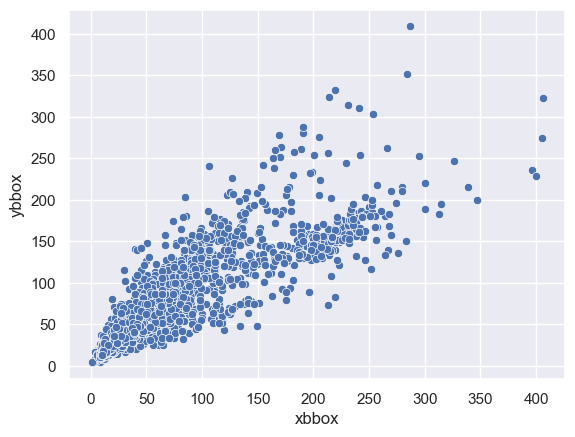

In [50]:
sns.scatterplot(data = data, x = 'xbbox', y = 'ybbox')
plt.show()

In [51]:
data = data.astype('string')

In [ ]:
def create_labels(image_list, data_name):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in fileNames:
        data = df[df.file==name]
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class']+" "+row["x_center"]+" "+row["y_center"]\
                        +" "+row["box_height"]+" "+row["box_width"])
            
        text = "\n".join(box_list)
        with open("./yolov5/data/"+data_name+"/labels/"+name+".txt", "w") as file:
            file.write(text)   

In [118]:
def create_labels(image_list, data_name):
    fileNames = [x.split('.')[0] for x in image_list]
    
    for name in fileNames:
        df = data[data.name==name]
        box_list = []
        
        for index in range(len(df)):
            row = df.iloc[index]
            box_list.append(row['class']+' '+row['x_centre']+' '+row['y_centre']\
                            +' '+ row['box_height']+' '+row['box_width'])
            
        text = '\n'.join(box_list)
        with open('/Users/antipins/Documents/Mask_Detected/yolov5/data/'+data_name+'/labels/'+name+'.txt', 'w') as file:
            file.write(text)

In [119]:
create_labels(train, 'train')
create_labels(test, 'test')
create_labels(val, 'val')

In [123]:
from IPython.display import Image, Video, clear_output  # to display images
import torch
from yolov5 import utils
display = utils.notebook_init()

YOLOv5  v7.0-203-g0897415 Python-3.10.9 torch-2.0.1 CPU


Setup complete  (4 CPUs, 7.9 GB RAM, 89.0/111.2 GB disk)


In [131]:
yaml_text = """train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

In [132]:
with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

In [141]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [142]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
    ]

In [145]:
# train yolov5s on custom data for 100 epochs
# time its performance

start = datetime.now()
!python train.py --img 640 --batch 32 --epochs 100 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache
end = datetime.now()

train: weights='', cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
From https://github.com/ultralytics/yolov5
   0897415..dd10481  master     -> origin/master
github:  YOLOv5 is out of date by 7 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5  v7.0-203-g0897415 Python-3.10.9 torch-2.0.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentu

In [146]:
print("Runtime =",end-start)

Runtime = 0:03:42.772634


In [147]:
img = plt.imread('runs/train/yolov5s_results/train_batch0.jpg')
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'runs/train/yolov5s_results/train_batch0.jpg'